In [1]:
import pandas as pd
import numpy as np

from datetime import datetime


pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

# Library

In [2]:
def counter_nan(series):
    return sum(series.isna())


def get_percentage_missing_data(df, threshold, show_percentage=False):
    '''Inputs: Datframe, thresold
    Function: return the features with more than thresold of missing data'''
    rows=df.shape[0]
    missing_features = []
    perc_missing_features = {}
    for column in df.columns:
        counter_perc = counter_nan(df[column])/rows
        perc_missing_features[column] = round(counter_perc*100, 2)
        if counter_perc > threshold:
            missing_features.append(column)
        else:
            continue
            
    if show_percentage:
        print(perc_missing_features)
    else:
        pass
    return missing_features
# Fill nan employment status clients with indefined
def fill_nan_employment(df):
    df['employment_status_clients'] = df['employment_status_clients'].replace(to_replace=np.nan, value='non-defined')


    
    
def birthday_to_age(string_date):
    current_year = 2018
    year_birthday = int(string_date.split('-')[0])
    age = 2018-year_birthday
    return age



def get_interest_data(previous_loan_df):
    '''Input: dataframe with the previous loans data
    Function: add two new columns to the dataframe containing the interest rate and the rate amount'''
    total_due = previous_loan_df['totaldue']
    loan_amount = previous_loan_df['loanamount']
    interest = total_due-loan_amount
    interest_rate = round((interest/loan_amount)*100,2)
    previous_loan_df['interest'] = interest
    previous_loan_df['interest_rate'] = interest_rate
    
    

def scale_termdays(previous_loan_df):
    '''Scale termdays using a year as unit'''
    previous_loan_df['termdays'] = round(previous_loan_df['termdays']/365, 2)
    
    
    
def get_date_features(df, keep_customer_id=False):
    '''Return a vector with the name of the date features'''
    
    if keep_customer_id:
        date_features = ['customerid']
    else:
        date_features = []
        
    for column in df.columns:
        if 'date' in column:
            date_features.append(column)
        else:
            continue
    return date_features



def get_non_date_features(df, keep_customer_id=False):
    '''Return a vector with the non date features'''
    if keep_customer_id:
        non_date_features = ['customerid']
    else:
        non_date_features = []
        
    for column in df.columns[1:]:
        if 'date' not in column:
            non_date_features.append(column)
        else:
            continue
    return non_date_features

    

def string_to_datetime(df):
    '''Convert date with string format into date variables'''
    for date_feature in get_date_features(df):
        df[date_feature] = df[date_feature].apply(lambda date: datetime.strptime(date.split(' ')[0], '%Y-%m-%d'))
    

    
def differentiate_dates(df, columns_to_differentiate=[]):
    '''Create a new column in which we store the distance between two dates'''
    #Days scale
    name_new_column = 'diff_'+columns_to_differentiate[0]+'_'+columns_to_differentiate[1]
    sec_in_day = 60*60*24
    #
    df[name_new_column] = df[columns_to_differentiate[0]] - df[columns_to_differentiate[1]]
    df[name_new_column] = df[name_new_column].apply(lambda x: round((x.total_seconds()/sec_in_day), 2))
    
    
def date_to_day(df):
    '''Create a new variable containing in which day of the week the due and the repaid took place'''
    columns_map = {
        'firstrepaiddate': 'repaid_dayofweek',
        'firstduedate': 'due_dayofweek'
    }
    for key, value in columns_map.items():
        df[value] = df[key].apply(lambda date: datetime.weekday(date))
        
        
        
def is_month_start(df):
        columns_map = {
        'firstrepaiddate': 'is_month_start_repaid',
        'firstduedate': 'is_month_start_due'
    }
        for key, value in columns_map.items():
            df[value] = df[key].apply(lambda date: 1 if date.day == 1 else 0)
            

def get_statistics_by_customer(df):
    '''Return a df with the aggregated data by customer
    
    '''
    stats = ['max', 'min', 'mean']
    df_dict = {}
    for stat in stats:
        if stat == 'max':
            rename_feature = {}
            for column in df.columns[2:]:
                rename_feature[column] = column+'_'+stat
            df_dict[stat] = df.groupby(['customerid']).max()
            df_dict[stat] = df_dict[stat].rename(columns=rename_feature)
            df_dict[stat] = df_dict[stat].drop(columns=['loannumber'])
        elif stat == 'min':
            rename_feature = {}
            for column in df.columns[2:]:
                rename_feature[column] = column+'_'+stat
            df_dict[stat] = df.groupby(['customerid']).min()
            df_dict[stat] = df_dict[stat].rename(columns=rename_feature)
            df_dict[stat] = df_dict[stat].drop(columns=['loannumber'])
        elif stat == 'mean':
            rename_feature = {}
            for column in df.columns[2:]:
                rename_feature[column] = column+'_'+stat
            df_dict[stat] = df.groupby(['customerid']).mean()
            df_dict[stat] = df_dict[stat].rename(columns=rename_feature)
            df_dict[stat] = df_dict[stat].drop(columns=['loannumber'])
            
    df_stat = pd.concat([df_dict['max'], df_dict['min'], df_dict['mean']], axis=1)
    
    return df_stat

In [3]:
def get_final_df(demographics, prev_loans, perf, is_train_data=True):
    #Drop columns with high percentage of missing values
    columns_to_drop = get_percentage_missing_data(demographics, 0.8, show_percentage=False)
    fill_nan_employment(demographics)
    demographics = demographics.drop(columns=columns_to_drop)
    #Transform birthdate in current age of each customer
    demographics['birthdate'] = demographics['birthdate'].apply(birthday_to_age)
    #Transform prevloans
        #payment info
    get_interest_data(prev_loans)
    scale_termdays(prev_loans)
        #date features treatment
    date_features_df = prev_loans.drop(columns=get_non_date_features(prev_loans))
        #String dates to datetime format
    string_to_datetime(date_features_df)
        #Create a two features tha computes the 'speed' of repayment
    differentiate_dates(date_features_df, ['firstduedate', 'firstrepaiddate'])
    differentiate_dates(date_features_df, ['closeddate', 'creationdate'])
        #Which day of the week the due and the repaid took place
    date_to_day(date_features_df)
        #Merge the transformed date features with the prevloans data
    prev_loans = pd.concat([prev_loans,date_features_df.drop(columns=get_date_features(prev_loans, keep_customer_id=True))], axis=1)
        #Non relevant variables once transformed the data
    columns_to_drop = ['systemloanid', 'approveddate', 'creationdate', 'closeddate', 'referredby', 'firstduedate',
                  'firstrepaiddate']
    prev_loans = prev_loans.drop(columns=columns_to_drop)
        #final prev loans data
    prev_loans = get_statistics_by_customer(prev_loans)
    prev_loans['customerid'] = prev_loans.index
    prev_loans = prev_loans.reset_index(drop=True)
    
    #Merge prevloans data with demographic data
    transformed_data = demographics.merge(prev_loans, how='inner', on=['customerid'])
    final_data = perf.merge(transformed_data, how='inner', on=['customerid'])
    
    #Drop dates loans
    final_data = final_data.drop(columns=['approveddate', 'creationdate', 'referredby'])
    #one hot encoding
    final_data = pd.get_dummies(final_data, columns=['bank_account_type', 'bank_name_clients', 'employment_status_clients'])
    #Encode good_bad_flag: Bad=1 Good=0
    if is_train_data:
        final_data['good_bad_flag'] = final_data['good_bad_flag'].apply(lambda x: 1 if x=='Bad' else 0)
        final_data = final_data.drop(columns=['customerid', 'systemloanid'])
    else:
        pass
    #Reorder the columns by name. To avoid problems with get dummies when a category is not present
    #in the validation test.
    final_data = final_data.reindex(columns=sorted(final_data.columns))
    return final_data

-----

# Loading Data

In [4]:
train_perf = pd.read_csv('/Users/ayoubelqadi/PycharmProjects/zindi_paper/data/trainperf.csv', low_memory=False)
train_prevloans = pd.read_csv('/Users/ayoubelqadi/PycharmProjects/zindi_paper/data/trainprevloans.csv', low_memory=False)
train_demographics = pd.read_csv('/Users/ayoubelqadi/PycharmProjects/zindi_paper/data/traindemographics.csv', low_memory=False)


,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good
...,...,...,...,...,...,...,...,...,...,...
4363,8a858e6d58b0cc520158beeb14b22a5a,302003163,2,2017-07-30 09:19:42.000000,2017-07-30 08:18:30.000000,10000.0,13000.0,30,NaN,Bad
4364,8a858ee85cf400f5015cf44ab1c42d5c,301998967,2,2017-07-27 15:35:47.000000,2017-07-27 14:35:40.000000,10000.0,13000.0,30,NaN,Bad
4365,8a858f365b2547f3015b284597147c94,301995576,3,2017-07-25 16:25:57.000000,2017-07-25 15:24:47.000000,10000.0,11500.0,15,NaN,Bad
4366,8a858f935ca09667015ca0ee3bc63f51,301977679,2,2017-07-14 13:50:27.000000,2017-07-14 12:50:21.000000,10000.0,13000.0,30,8a858eda5c8863ff015c9dead65807bb,Bad


In [44]:
final = get_final_df(demographics=train_demographics, prev_loans=train_prevloans, perf=train_perf)


In [45]:
final.shape

(3272, 63)

In [46]:
X = final.drop(columns=['good_bad_flag']).to_numpy()
y = final['good_bad_flag'].to_numpy(dtype=np.int)
X.shape

(3272, 62)

In [47]:
sum(y==1)/len(y)

0.2176039119804401

-----

# XGBoost


In [48]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [49]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [51]:
#Optimized data structure for xgboost
data_matrix = xgb.DMatrix(data=X, label=y)
#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=435, test_size=0.25)
#Create the model
params = {
    'n_estimators': np.arange(500, 1100, 100),
    'learning_rate': np.arange(0.05, 0.35, 0.025),
    'max_depth': np.arange(3, 16, 16),
    'min_child_weight': np.arange(1, 9, 2),
    'gamma': np.arange(0, 0.5, 0.1),
    'colsample_bytree': np.arange(0.3, 0.9, 0.2),
    'subsample': np.arange(0, 1, 0.1)
}


#model = xgb.XGBClassifier(objective='binary:hinge', eval_metric=['error'])
#random_search = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=5, n_jobs=-1, cv=5)


### Results with parameters obtained in the paper

In [54]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
#Function to compute the main classification metrics
def classification_metrics(model):
    y_hat = model.predict(X_test)
    f1 = f1_score(y_true=y_test, y_pred=y_hat)
    f1 = round(f1*100, 4)
    accuracy = accuracy_score(y_true=y_test, y_pred=y_hat)
    accuracy = round(accuracy*100, 4)
    precision = precision_score(y_true=y_test, y_pred=y_hat)
    precision = round(precision*100, 4)
    recall = recall_score(y_true=y_test, y_pred=y_hat)
    recall = round(recall*100, 4)
    print('Accuracy = {}\nF1 = {}\nPrecision = {}\nRecall = {}\n'.format(accuracy, f1, precision, recall))

In [55]:
paper_params = {
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'subsample': 0.8,
    'reg_alpha': 1,
    'max_depth': 6,
    'objective': 'binary:logistic'
}

paper_model = xgb.XGBClassifier(**paper_params, use_label_encoder=False )
paper_model.fit(X_train, y_train)
classification_metrics(paper_model)





[21:41:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy = 78.8509
F1 = 32.1569
Precision = 56.9444
Recall = 22.4044



# Hyperparameter Tuning

In [12]:
#Grid seaarch printing function
params_grid = {
    'n_estimators': [900, 1000],
    'learning_rate': [ 0.2, 0.3],
    'max_depth': [6, 8],
    #'min_child_weight': np.arange(1, 9, 2),
    'gamma': [0.3],
    #'colsample_bytree': np.arange(0.3, 0.9, 0.2),
    'subsample': [0.8, 1]
}

model_gv = xgb.XGBClassifier(objective='binary:logistic', eval_metric=['auc'], use_label_encoder=False)
grid_search = GridSearchCV(model_gv, params_grid, cv=5, return_train_score=True, verbose=10, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)









Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  66 out of  80 | elapsed:  5.5min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  75 out of  80 | elapsed:  6.3min remaining:   25.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  6.4min finished


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, eval_metric=['auc'],
                                     gamma=None, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_e...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                    

In [148]:
#for i in range(len(grid_search.cv_results_['mean_test_score'])):
 #   print(grid_search.cv_results_['params'][i], round(grid_search.cv_results_['mean_test_score'][i], 3))


In [15]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
benchmark_model = xgb.XGBClassifier(**grid_search.best_params_, objective='binary:logistic', eval_metric=['auc'])
benchmark_model.fit(X_train, y_train)
y_hat = benchmark_model.predict(X_test)
f1 = f1_score(y_true=y_test, y_pred=y_hat)
accuracy = accuracy_score(y_true=y_test, y_pred=y_hat)
precision = precision_score(y_true=y_test, y_pred=y_hat)
recall = recall_score(y_true=y_test, y_pred=y_hat)

print('Accuracy = {}\nF1 = {}\nPrecision = {}\nRecall = {}\n'.format(accuracy, f1, precision, recall))


Accuracy = 0.7814814814814814
F1 = 0.358695652173913
Precision = 0.5038167938931297
Recall = 0.27848101265822783



In [72]:
X_train.shape

(2192, 62)

In [149]:
#for i in range(X_train.shape[1]):
 #   print('Feature {}: importance {}'.format(final.drop(columns=['good_bad_flag']).columns[i],  benchmark_model.feature_importances_[i]))


In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true=y_test, y_pred=y_hat)

array([[778,  65],
       [171,  66]])

In [65]:
confusion_matrix(y_true=y_test, y_pred=y_hat)

array([[811,  32],
       [192,  45]])

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [8]:
scaler = StandardScaler()
X = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=435, test_size=0.2)


xgb = XGBClassifier()


In [9]:
xgb.fit(X_train, y_train)

/Users/ayoubelqadi/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [10]:
probs = xgb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

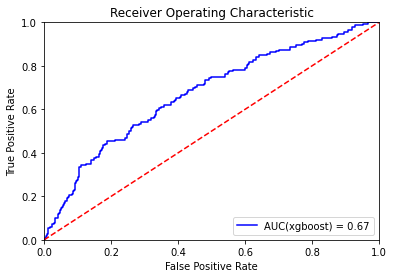

In [11]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC(xgboost) = %0.2f' % roc_auc)



plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

---

In [39]:
from sklearn.metrics import roc_auc_score, auc, roc_curve
def results_model_test(model_name):
    
    prob = model_name.predict_proba(X_test)
    pred = prob[:,1]
    fpr, tpr, threshold = roc_curve(y_test, pred)
    roc_auc = auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.legend(loc = 'lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [13]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


params = {
    'learning_rate': np.arange(0.05, 0.35, 0.025),
    'max_depth': np.arange(3, 16, 16),
    'min_child_weight': np.arange(1, 9, 2),
    'gamma': np.arange(0, 0.5, 0.1),
    'colsample_bytree': np.arange(0.3, 0.9, 0.2)
}

xgboost_cl = XGBClassifier()
random_search = RandomizedSearchCV(xgboost_cl, param_distributions=params, scoring='roc_auc', n_iter=5, n_jobs=-1, cv=5)

random_search.fit(X_train, y_train)

/Users/ayoubelqadi/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:19:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                   

[22:19:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


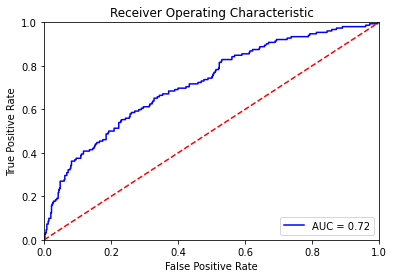

In [14]:
best_model = XGBClassifier(**random_search.best_params_)
best_model.fit(X_train, y_train)
results_model_test(best_model)

----
# Submit Data

In [37]:
test_perf = pd.read_csv('/Users/ayoubelqadi/PycharmProjects/zindi_paper/data/testperf.csv', low_memory=False)
test_prevloans = pd.read_csv('/Users/ayoubelqadi/PycharmProjects/zindi_paper/data/testprevloans.csv', low_memory=False)
test_demographics = pd.read_csv('/Users/ayoubelqadi/PycharmProjects/zindi_paper/data/testdemographics.csv', low_memory=False)
#test = get_final_df(demographics=test_demographics, prev_loans=test_prevloans, perf=test_perf, is_train_data=False)

In [38]:
def submit_function(test_perf, test_prevloans, test_demographics):
    test_data_set = get_final_df(demographics=test_demographics, prev_loans=test_prevloans, perf=test_perf, is_train_data=False)
    cutomer_id = test_data_set['customerid']
    #Add columns with dummies that not appears in test set
    for training_column in final.columns:
        if training_column in test.columns:
            pass
        elif training_column == 'good_bad_flag':
            pass
        else:
            test[training_column] = np.zeros(test.shape[0])
    #Convert to dgb matrix and to numpy
    X = test_data_set.drop(columns=['customerid', 'systemloanid']).to_numpy()
    #Scale test set
    scal = StandardScaler()
    X = scal.fit_transform(X)
    #X_matrix = xgb.DMatrix(data=X)
    y_hat = benchmark_model.predict(X)
    results = pd.DataFrame(columns=['customerID', 'Good_Bad_flag'])
    results['customerID'] = cutomer_id
    results['Good_Bad_flag'] = y_hat
    
    return results
    
    
    
    
    
    
    
    

In [30]:
#test
test_data_set = get_final_df(demographics=test_demographics, prev_loans=test_prevloans, perf=test_perf, is_train_data=False)
cutomer_id = test_data_set['customerid']
X = test_data_set.drop(columns=['customerid', 'systemloanid']).to_numpy()
scal = StandardScaler()

X = scal.fit_transform(X)
X

array([[-0.12598816, -0.47215457,  0.49674264, ...,  0.38163381,
         0.11688212, -0.45006695],
       [-0.12598816, -0.47215457,  0.49674264, ..., -0.61124554,
        -0.55515843, -0.45006695],
       [-0.12598816, -0.47215457,  0.49674264, ..., -0.61124554,
        -0.45733594,  0.80456614],
       ...,
       [-0.12598816, -0.47215457,  0.49674264, ..., -0.61124554,
        -0.45733594,  0.80456614],
       [-0.12598816, -0.47215457,  0.49674264, ..., -0.61124554,
        -0.45733594,  0.80456614],
       [-0.12598816, -0.47215457,  0.49674264, ..., -0.74914545,
        -0.75080342, -0.45006695]])

In [39]:
submit_function(test_perf, test_prevloans, test_demographics)

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58']
expected f60, f61, f59 in input data

In [35]:
final.columns

Index(['bank_account_type_Current', 'bank_account_type_Other',
       'bank_account_type_Savings', 'bank_name_clients_Access Bank',
       'bank_name_clients_Diamond Bank', 'bank_name_clients_EcoBank',
       'bank_name_clients_FCMB', 'bank_name_clients_Fidelity Bank',
       'bank_name_clients_First Bank', 'bank_name_clients_GT Bank',
       'bank_name_clients_Heritage Bank', 'bank_name_clients_Keystone Bank',
       'bank_name_clients_Skye Bank', 'bank_name_clients_Stanbic IBTC',
       'bank_name_clients_Standard Chartered',
       'bank_name_clients_Sterling Bank', 'bank_name_clients_UBA',
       'bank_name_clients_Union Bank', 'bank_name_clients_Unity Bank',
       'bank_name_clients_Wema Bank', 'bank_name_clients_Zenith Bank',
       'birthdate', 'diff_closeddate_creationdate_max',
       'diff_closeddate_creationdate_mean', 'diff_closeddate_creationdate_min',
       'diff_firstduedate_firstrepaiddate_max',
       'diff_firstduedate_firstrepaiddate_mean',
       'diff_firstduedat

In [36]:
test.columns

Index(['bank_account_type_Current', 'bank_account_type_Other',
       'bank_account_type_Savings', 'bank_name_clients_Access Bank',
       'bank_name_clients_Diamond Bank', 'bank_name_clients_EcoBank',
       'bank_name_clients_FCMB', 'bank_name_clients_Fidelity Bank',
       'bank_name_clients_First Bank', 'bank_name_clients_GT Bank',
       'bank_name_clients_Heritage Bank', 'bank_name_clients_Keystone Bank',
       'bank_name_clients_Skye Bank', 'bank_name_clients_Stanbic IBTC',
       'bank_name_clients_Standard Chartered',
       'bank_name_clients_Sterling Bank', 'bank_name_clients_UBA',
       'bank_name_clients_Union Bank', 'bank_name_clients_Unity Bank',
       'bank_name_clients_Wema Bank', 'bank_name_clients_Zenith Bank',
       'birthdate', 'customerid', 'diff_closeddate_creationdate_max',
       'diff_closeddate_creationdate_mean', 'diff_closeddate_creationdate_min',
       'diff_firstduedate_firstrepaiddate_max',
       'diff_firstduedate_firstrepaiddate_mean',
       'di

In [166]:
test.shape

(384, 64)

In [168]:
final.shape

(3272, 63)